# SUPG stabilization of the steady advection-diffusion-reaction equation

strong form of the boundary value problem
$$
\begin{align*}
&\text{Find}~u(\textbf{x}): \Omega \to \mathbb{R}~	ext{such that} \\
&\begin{cases}
\textbf{a}\cdot\nabla u= \nabla\cdot(\mathsf{D}\cdot\nabla u) + Ru + J & \forall\textbf{x}\in\Omega \\
u=u_{\text{D}} & \forall \textbf{x}\in\partial\Omega_{\text{D}} \\
\textbf{n}\cdot(\mathsf{D}\cdot\nabla{u}) = u_{\text{N}} & \forall\textbf{x}\in\partial\Omega_{\text{N}}=\partial\Omega/\partial\Omega_{\text{D}}
\end{cases}~.
\end{align*}
$$

stabilized weak form
$$
\begin{align*}
&\text{Find}~u\in V~	ext{such that} \\
&F(u,v)+F_{\text{SUPG}}(u,v)=0 \quad\forall v\in V~.
\end{align*}
$$

stabilization term
$$
F_{\text{SUPG}}(u,v)=...
$$


## Example: stabilizing a boundary layer on an interval

Donea, J. & Huerta, A. (2003). *Finite Element Methods for Flow Problems*. $\S 2.3.1$

$$
\mathbb{S}=
\begin{cases}
\Omega = [0, 1] \\
u_{\text{D}}(x=0,1)=0 \\
\textbf{a}=a\,\textbf{e}_x \\
\mathsf{D}=D\mathsf{I} \\
R=0 \\
J = 1 \\
u_{\text{e}}(x)=\frac{1}{a}\frac{(x-e^{ax/D})}{1-e^{a/D}}
\end{cases}
$$


In [ ]:
import numpy as np
import scipy.special as sp
from ufl import SpatialCoordinate, as_vector, cos, sin, CellDiameter
from lucifex.mesh import interval_mesh
from lucifex.fem import Function, Constant
from lucifex.solver import BoundaryValueProblem, bvp, BoundaryConditions
from lucifex.viz import plot_line
from lucifex.io import write, get_ipynb_file_name
from lucifex.utils.py_utils import nested_dict
from lucifex.pde.advection_diffusion import steady_advection_diffusion
from lucifex.pde.supg import peclet



def create_bl_solver(
    supg: str | None,
    Nx: int,
    a: float,
    d: float, 
    j: float | None = 1.0,
    Lx: float = 1.0,
    dirichlet: tuple[float, float] = (0.0, 0.0),
) -> BoundaryValueProblem:
    mesh = interval_mesh(Lx, Nx)
    a = Constant(mesh, (a, ), name='a')
    d = Constant(mesh, d, name='d')
    if j is not None:
        j = Constant(mesh, j, name='s')
    u = Function((mesh, 'P', 1), name='u')
    bcs = BoundaryConditions(
        ('dirichlet', lambda x: x[0], dirichlet[0]),
        ('dirichlet', lambda x: x[0] - Lx, dirichlet[1])
    )
    u_solver = bvp(steady_advection_diffusion, bcs=bcs)(
        u, a, d, j=j, supg=supg,
    )
    return u_solver


Lx = 1.0
Nx = 10
h = Lx / Nx
a = 1.0
j = 1.0

supg_opts = (None, 'coth', 'upwind')
d_opts = (0.2, 1/18, 1/100)
bl_solutions = nested_dict(dict[float, dict[str | None, Function]], depth=2)
for d in d_opts:
    for supg in supg_opts:
        h = Lx / Nx
        Pe = peclet(h, a, d)
        u_solver = create_bl_solver(supg, Nx, a, d, j, Lx)
        u_solver.solve()
        bl_solutions[d][supg] = u_solver.solution

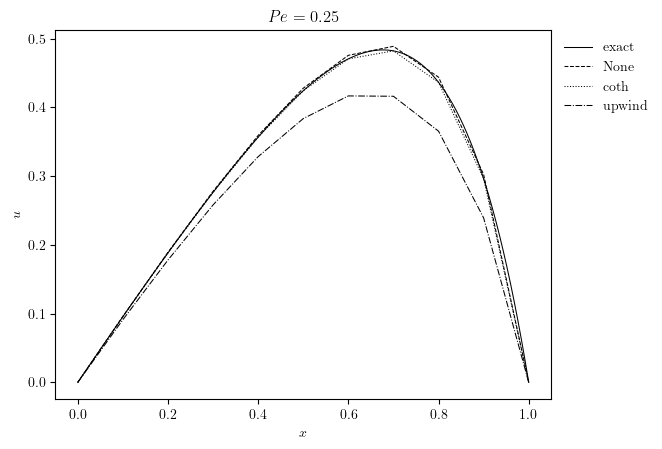

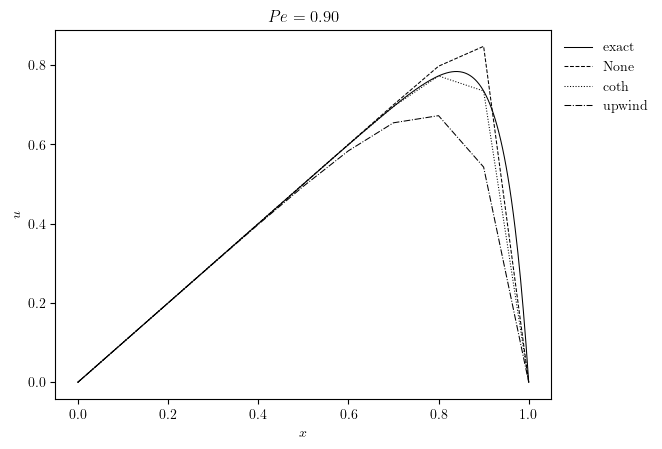

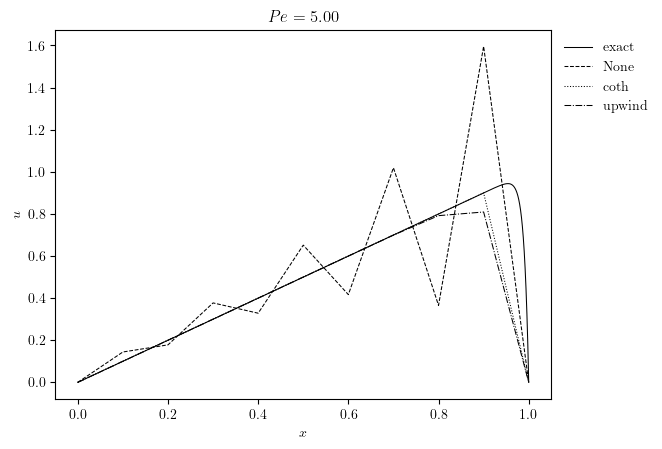

In [2]:
def exact_bl(
    x: np.ndarray, 
    a: float, 
    d: float,
) -> np.ndarray:    
    return (1 / a) * (x - (1 - np.exp(a * x / d)) / (1.0 - np.exp(a / d)))

x = np.linspace(0, Lx, num=500)

for d in d_opts:
    lines = [(x, exact_bl(x, a, d))]
    legend_labels = ['exact']
    for supg in supg_opts:
        lines.append(bl_solutions[d][supg])
        legend_labels.append(supg)
    Pe = peclet(h, a, d)
    fig, ax = plot_line(lines, legend_labels, x_label='$x$', y_label='$u$', title=f'$Pe={Pe:.2f}$')
    write(fig, f'{get_ipynb_file_name()}_Pe={Pe:.2f}', './figures', close=False, pickle=False)

## Example: the Hemker problem

Donea, J. & Huerta, A. (2003). *Finite Element Methods for Flow Problems*. $\S 2.6.6$

$$
\begin{cases}
\Omega = [-1, 1] \\
u_{\text{D}}(x=-1)=-2 \\
u_{\text{D}}(x=1)=0 \\
\textbf{a}=x\,\textbf{e}_x \\
\mathsf{D}=-\nu\mathsf{I} \\
R=0 \\
J = -D\pi^2\cos(\pi x) -\pi x\sin(\pi x) \\
u_{\text{e}}(x)=\cos(\pi x)+\frac{\text{erf}\left(\frac{x}{\sqrt{2D}}\right)}{\text{erf}\left(\frac{1}{\sqrt{2D}}\right)}
\end{cases}
$$

In [ ]:
def create_hemker_solver(
    supg: str | None,
    Nx: int,
    nu: float, 
    Lx: tuple[float, float] = (-1.0, 1.0),
    dirichlet: tuple[float, float] = (-2.0, 0.0),
) -> BoundaryValueProblem:
    mesh = interval_mesh(Lx, Nx)
    bcs = BoundaryConditions(
        ('dirichlet', lambda x: x[0] - Lx[0], dirichlet[0]),
        ('dirichlet', lambda x: x[0] - Lx[1], dirichlet[1])
    )
    x = SpatialCoordinate(mesh)
    a = as_vector((x[0], ))
    d = Constant(mesh, -nu, name='d')
    nu = Constant(mesh, nu, name='nu')
    j = -nu * np.pi**2 * cos(np.pi * x[0]) - np.pi * x[0] * sin(np.pi * x[0])
    u = Function((mesh, 'P', 1), name='u')
    h = CellDiameter(mesh)
    u_solver = bvp(steady_advection_diffusion, bcs=bcs)(
        u, a, d, j=j, supg=supg, h=h,
    )
    return u_solver


Nx = 20
nu = 1e-6
supg_opts = (None, 'coth')
hemker_solutions: dict[str | None, Function] = nested_dict()

for supg in supg_opts:
    u_solver = create_hemker_solver(supg, Nx, nu)
    u_solver.solve()
    hemker_solutions[supg] = u_solver.solution

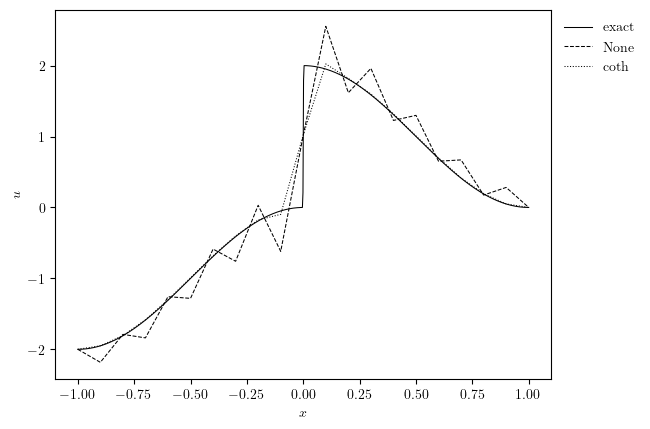

: 

In [ ]:
def exact_hemker(
    x: np.ndarray,   
    d: float,
) -> np.ndarray:    
    return np.cos(np.pi * x) + sp.erf(x/np.sqrt(2 * d)) / sp.erf(1/np.sqrt(2 * d))


x = np.linspace(-Lx, Lx, num=800)

lines = [(x, exact_hemker(x, nu))]
legend_labels = ['exact']
for supg in supg_opts:
    lines.append(hemker_solutions[supg])
    legend_labels.append(supg)

fig, ax = plot_line(lines, legend_labels, x_label='$x$', y_label='$u$')
write(fig, f'{get_ipynb_file_name()}_hemker', './figures', close=False, pickle=False)